In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
## load mnist dataset
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

print ('==>>> total trainning batch number: {}'.format(len(trainloader)))
print ('==>>> total testing batch number: {}'.format(len(testloader)))

use_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
==>>> total trainning batch number: 50000
==>>> total testing batch number: 10000


In [2]:
def resnet_feat():
    import torchvision.models as models
    
    model = models.resnet101(pretrained=True)
    modules=list(model.children())[:-1]
    model=nn.Sequential(*modules)
    model.eval()
    if use_gpu:
        print('yes')
        model = model.cuda()
    return model

In [3]:
model  = resnet_feat()
feature_array = np.zeros(2049)
i = 0
for iter, testdata in enumerate(testloader, 0):
    test_inputs, test_file_name = testdata
    #test_inputs = torch.cat((test_inputs,test_inputs,test_inputs),dim=1)
    #print(test_inputs.shape, type(test_inputs), test_file_name)
    if use_gpu:
        test_inputs = Variable(test_inputs.cuda())
    else: test_inputs = Variable(test_inputs)
    
    test_outputs = model(test_inputs)
    test_outputs = test_outputs.cpu().data.numpy()        

    # this is not required for the alexnet 
    # for resnet to squeeze the dimension from the avg pool layers
    test_outputs = np.squeeze(test_outputs)
    # sometimes due to the selection of a particular batch size 
    # the output becomes a 1d vector instead of bsize X dim 2d vector
    if (len(test_outputs.shape) != 2):
        test_outputs = np.reshape(test_outputs,(1, -1))
    
    test_outputs = test_outputs.squeeze()
    labels = test_file_name.cpu().data.numpy()
    if i%500==0: 
        print(labels)
    #print(np.concatenate((test_outputs,labels)))
    feature_array = np.vstack((feature_array,np.concatenate((test_outputs,labels))))
    
    i+=1

yes
[3]
[4]
[5]
[1]
[1]
[4]
[5]
[1]
[8]
[3]
[7]
[8]
[8]
[7]
[2]
[6]
[9]
[4]
[8]
[9]


In [4]:
feature_array[1,:2048]

array([7.46911407e-01, 1.98615059e-01, 1.38918364e+00, ...,
       9.52754926e-04, 6.94933310e-02, 4.42206085e-01])

In [5]:
import pandas as pd

In [6]:
feature_df = pd.DataFrame(feature_array)
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.746911,0.198615,1.389184,0.586219,0.066621,0.012767,0.594526,0.421935,0.878378,0.077480,...,0.705776,0.150223,0.980435,1.832706,0.550708,1.159052,0.000953,0.069493,0.442206,3.0
2,0.219836,0.148590,1.520749,0.281201,0.116259,0.316204,0.980995,0.627611,2.882089,0.364398,...,0.665533,1.820071,0.722318,0.639770,0.402697,0.947082,0.113394,1.736066,0.230969,8.0
3,0.353577,0.560950,1.854206,0.737399,0.105683,0.388854,0.815959,0.856755,0.618814,0.318661,...,0.022704,1.330439,0.670860,0.271427,0.795468,1.848424,0.287867,0.986888,0.604345,8.0
4,0.949554,0.066645,1.748269,1.043568,0.084872,0.000000,0.988070,1.675455,0.491809,0.830022,...,0.035315,0.234666,0.163133,1.088633,1.588583,1.054879,0.223051,0.575028,0.026455,0.0


In [7]:
feature_df = feature_df.rename(columns={2048:'labels'})
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,labels
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.746911,0.198615,1.389184,0.586219,0.066621,0.012767,0.594526,0.421935,0.878378,0.077480,...,0.705776,0.150223,0.980435,1.832706,0.550708,1.159052,0.000953,0.069493,0.442206,3.0
2,0.219836,0.148590,1.520749,0.281201,0.116259,0.316204,0.980995,0.627611,2.882089,0.364398,...,0.665533,1.820071,0.722318,0.639770,0.402697,0.947082,0.113394,1.736066,0.230969,8.0
3,0.353577,0.560950,1.854206,0.737399,0.105683,0.388854,0.815959,0.856755,0.618814,0.318661,...,0.022704,1.330439,0.670860,0.271427,0.795468,1.848424,0.287867,0.986888,0.604345,8.0
4,0.949554,0.066645,1.748269,1.043568,0.084872,0.000000,0.988070,1.675455,0.491809,0.830022,...,0.035315,0.234666,0.163133,1.088633,1.588583,1.054879,0.223051,0.575028,0.026455,0.0


In [14]:
feature_array[1,:2048]

array([7.46911407e-01, 1.98615059e-01, 1.38918364e+00, ...,
       9.52754926e-04, 6.94933310e-02, 4.42206085e-01])

In [17]:
import time

from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature_array)


print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.863s...
[t-SNE] Computed neighbors for 10001 samples in 338.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 4.587927
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.945152
[t-SNE] 

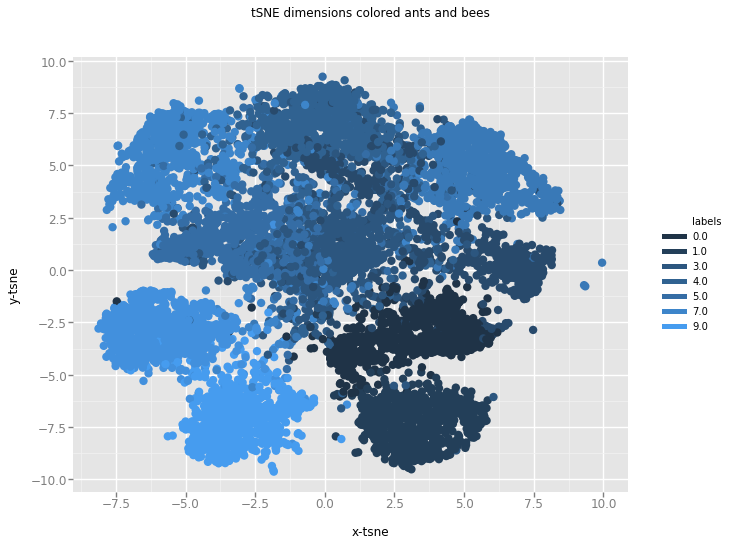

<ggplot: (-9223363302567386466)>

In [20]:
from ggplot import *


df_tsne = feature_df.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='labels') ) \
        + geom_point(size=70,alpha=1) \
        + ggtitle("tSNE dimensions colored ants and bees")
chart

In [10]:
df_tsne.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.746911,0.198615,1.389184,0.586219,0.066621,0.012767,0.594526,0.421935,0.878378,0.077480,...,0.705776,0.150223,0.980435,1.832706,0.550708,1.159052,0.000953,0.069493,0.442206,3.0
2,0.219836,0.148590,1.520749,0.281201,0.116259,0.316204,0.980995,0.627611,2.882089,0.364398,...,0.665533,1.820071,0.722318,0.639770,0.402697,0.947082,0.113394,1.736066,0.230969,8.0
3,0.353577,0.560950,1.854206,0.737399,0.105683,0.388854,0.815959,0.856755,0.618814,0.318661,...,0.022704,1.330439,0.670860,0.271427,0.795468,1.848424,0.287867,0.986888,0.604345,8.0
4,0.949554,0.066645,1.748269,1.043568,0.084872,0.000000,0.988070,1.675455,0.491809,0.830022,...,0.035315,0.234666,0.163133,1.088633,1.588583,1.054879,0.223051,0.575028,0.026455,0.0
